# Predicting chlorophyll content using PROSAIL and random forest

Datasets containing spectral reflectance curves and  corresponding chlorophyll content is provided a model is to trained to predict chlorophyl content.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import prosail
from scipy.interpolate import interp1d

### Loading the data

In [2]:
import os

#checking the current working directory
print(os.getcwd())

/Users/ridhinpaul/Developer/Remote sensing of agriculture and vegetation/Session1


In [3]:
citrus_spectra = pd.read_csv("data/citrus_spectra.csv", sep=";")  #Contains spectral data of the leaf
citrus_chl = pd.read_csv("data/citrus_meas_Chl.csv", sep=";") #chlorophyl content

##### Extracting wavelength, spectral reflectance and chlorophyll content

In [4]:
wave = citrus_spectra["wavelength"].values
spectra = citrus_spectra.iloc[:,1:].values.T
Cab = citrus_chl["Ctot"].values

#### Resampling data to reduce computational cost

1. Reampling by interpolation

In [5]:
def spectralResamplingInterpolation(originalWave, spectra, newWave):
    resampledSpectra = []
    for i in range(spectra.shape[0]):
        #For values outside the bounds of originalWave it extrapolates
        f = interp1d(originalWave, spectra[i,:], kind='cubic', bounds_error=False, fill_value='extrapolate')
        resampledSpectra.append(f(newWave))
    return np.array(resampledSpectra)

In [6]:
newWave1 = np.arange(350, 2510, 5) 

resampledSpectraInterp = spectralResamplingInterpolation(wave, spectra, newWave1)
print("Resampled Spectra Shape:", resampledSpectraInterp.shape) 

Resampled Spectra Shape: (65, 432)


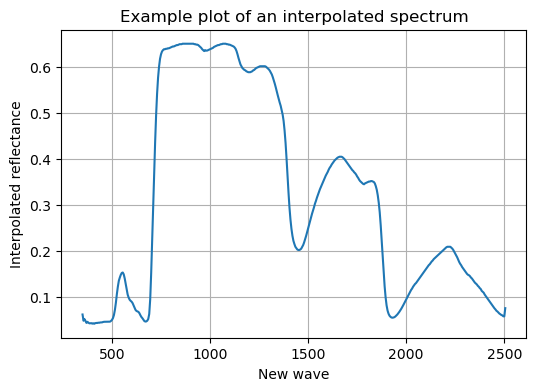

In [7]:
plt.figure(figsize=(6,4))
plt.plot(newWave1, resampledSpectraInterp[1,:])
plt.xlabel("New wave")
plt.ylabel("Interpolated reflectance")
plt.title("Example plot of an interpolated spectrum")
plt.grid(True)
plt.show()

2. Resampling by decimation (downsampling)

Sampling every nth point from dataset, it's fast but losses fine details.

In [8]:
def spectralResamplingDecimation(originalWave, spectra, step = 2):
    newWave = originalWave[:spectra.shape[1]][::step]
    resampledSpectra = spectra[:, ::step]
    return newWave, resampledSpectra

In [9]:
resampledDecim = spectralResamplingDecimation(wave, spectra, step=2)
newWave2 =  resampledDecim[0]
resampledSpectraDecim = resampledDecim[1]

print("Resampled Spectra Shape:", resampledSpectraDecim.shape) 

Resampled Spectra Shape: (65, 1076)


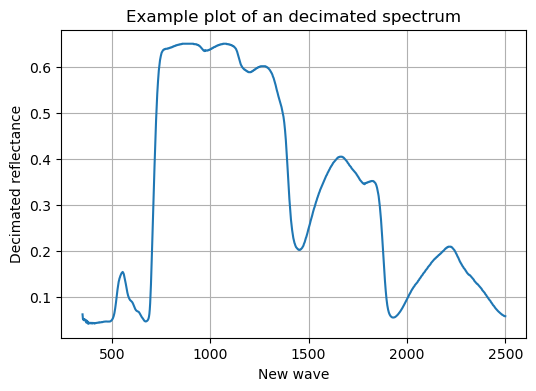

In [10]:
plt.figure(figsize=(6,4))
plt.plot(newWave2, resampledSpectraDecim[1,:])
plt.xlabel("New wave")
plt.ylabel("Decimated reflectance")
plt.title("Example plot of an decimated spectrum")
plt.grid(True)
plt.show()

### Creating a lookup table using prospect

 Spectra is simulated with prospect model creating a LUT which will act as the training dataset.

In [11]:
#defining the range of prospect model parameters

N_values = np.linspace(1, 5, 500)
Cab_values = np.linspace(0, 100, 500)
Car_values = np.linspace(0, 30, 500)
Cbrown_values = np.linspace(0, 1, 500)
Cw_values = np.linspace(5e-5, 0.04, 500)
Cm_values = np.linspace(0.002, 0.018, 500)

# Creating a DataFrame with random parameter combinations
param_list = pd.DataFrame({
    "N": np.random.choice(N_values, 500),
    "Cab": np.random.choice(Cab_values, 500),
    "Car": np.random.choice(Car_values, 500),
    "Cbrown": np.random.choice(Cbrown_values, 500),
    "Cw": np.random.choice(Cw_values, 500),
    "Cm": np.random.choice(Cm_values, 500)
})


#### Running the prospect model

In [12]:
simulatedSpectra = []

#iterate over each rows which is returned as tuple in vals
for _, vals in param_list.iterrows():
    _, refl, _ = prosail.run_prospect(vals.N, vals.Cab, vals.Car, vals.Cbrown, vals.Cw, vals.Cm)
    refl = refl[:len(wave)] 
    simulatedSpectra.append(refl)

simulatedSpectra = np.array(simulatedSpectra)

print(simulatedSpectra.shape)

(500, 2101)


#### Resampling simulated spectra

In [13]:
#Resampling with interpolation

newWave1 = np.arange(350, 2510, 5) 

simulatedSpectraResampleInter = spectralResamplingInterpolation(wave[:simulatedSpectra.shape[1]], simulatedSpectra, newWave1)

print(np.shape(simulatedSpectraResampleInter))

(500, 432)


### Training the model

1. Random forest model

- Sampled by interpolation

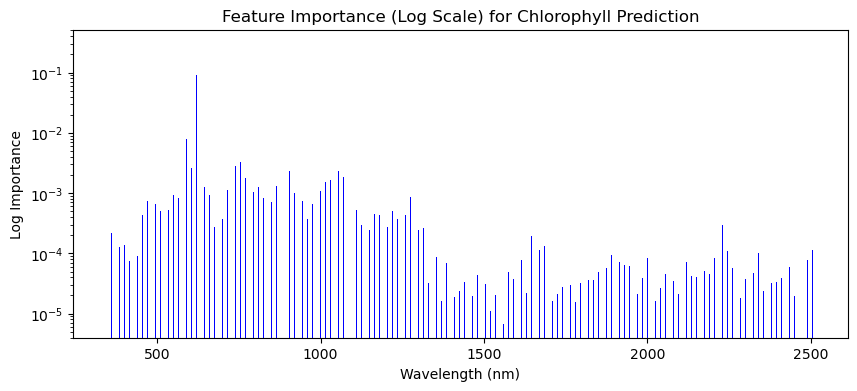

In [14]:
x = simulatedSpectraResampleInter
y = param_list["Cab"].values


rf_model1 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model1.fit(x, y)

plt.figure(figsize=(10, 4))
plt.bar(newWave1, rf_model1.feature_importances_, color="blue")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Log Importance")
plt.title("Feature Importance (Log Scale) for Chlorophyll Prediction")
plt.yscale("log")
plt.show()

#### Predicting the chlorophyll content and model evaluation

In [15]:
Cab_pred1 = rf_model1.predict(resampledSpectraInterp)

R2 = metrics.r2_score(Cab, Cab_pred1)
RMSE = np.sqrt(metrics.mean_squared_error(Cab, Cab_pred1))

print(f"Model R²: {R2:.2f}")
print(f"Model RMSE: {RMSE:.2f}")

Model R²: 0.49
Model RMSE: 12.18


- Sampled by decimation

In [16]:
newWave2, simulatedSpectraResampleDecim =  spectralResamplingDecimation(wave, simulatedSpectra, step=2)

print(simulatedSpectraResampleDecim.shape)
print(newWave2.shape)

(500, 1051)
(1051,)


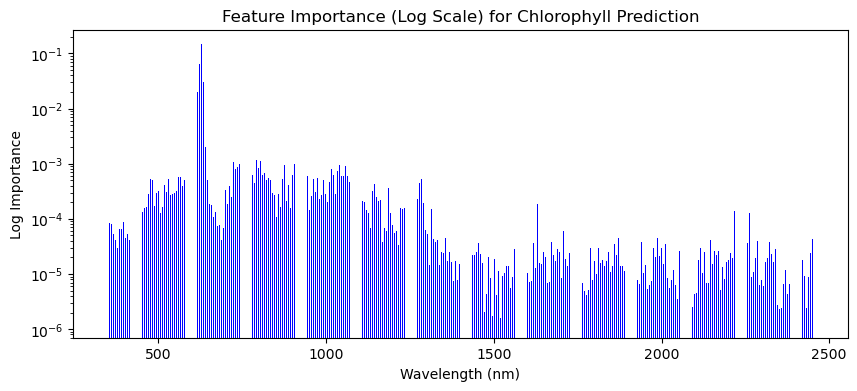

In [17]:
x = simulatedSpectraResampleDecim
y = param_list["Cab"].values


rf_model2 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model2.fit(x, y)

plt.figure(figsize=(10, 4))
plt.bar(newWave2, rf_model2.feature_importances_, color="blue")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Log Importance")
plt.title("Feature Importance (Log Scale) for Chlorophyll Prediction")
plt.yscale("log")
plt.show()

#### Predicting the chlorophyll content and model evaluation

- Creating test data

In [18]:
#To allign with model input parameters
newWaveTest = np.arange(350, 2510, 2160/1051) 

resampledSpectraDecim = spectralResamplingInterpolation(wave, spectra, newWaveTest)
print("Resampled Spectra Shape:", resampledSpectraDecim.shape) 

Resampled Spectra Shape: (65, 1051)


In [19]:
Cab_pred2 = rf_model2.predict(resampledSpectraDecim)

R2 = metrics.r2_score(Cab, Cab_pred2)
RMSE = np.sqrt(metrics.mean_squared_error(Cab, Cab_pred2))

print(f"Model R²: {R2:.2f}")
print(f"Model RMSE: {RMSE:.2f}")

Model R²: 0.64
Model RMSE: 10.30


### Visualising results

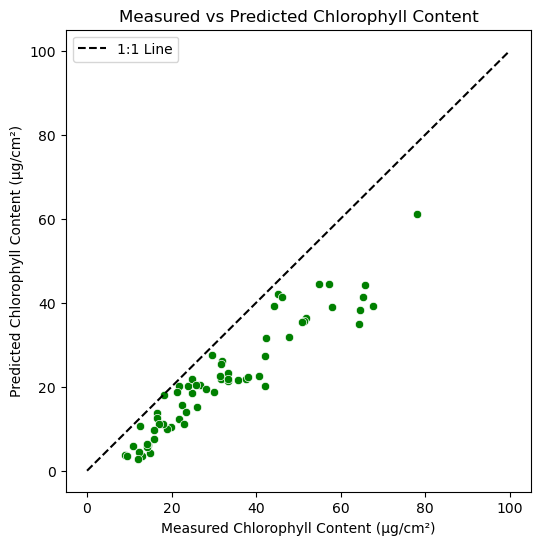

In [20]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=Cab, y=Cab_pred1, color="green")
plt.plot([0, 100], [0, 100], 'k--', label="1:1 Line")
plt.xlabel("Measured Chlorophyll Content (µg/cm²)")
plt.ylabel("Predicted Chlorophyll Content (µg/cm²)")
plt.title("Measured vs Predicted Chlorophyll Content")
plt.legend()
plt.show()


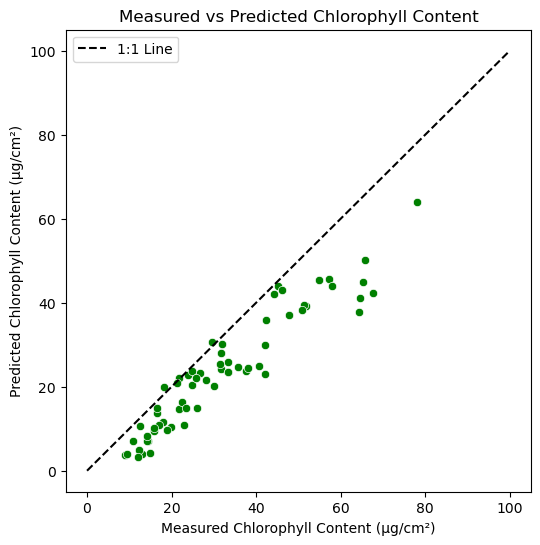

In [21]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=Cab, y=Cab_pred2, color="green")
plt.plot([0, 100], [0, 100], 'k--', label="1:1 Line")
plt.xlabel("Measured Chlorophyll Content (µg/cm²)")
plt.ylabel("Predicted Chlorophyll Content (µg/cm²)")
plt.title("Measured vs Predicted Chlorophyll Content")
plt.legend()
plt.show()